In [1]:
import numpy as np
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt
from scipy.io import wavfile
import pywt

In [2]:
def normalize(signal):
    signal = signal.astype(np.float64)

    mean = np.mean(signal)
    centered_signal = signal - mean

    max_abs_value = np.max(np.abs(centered_signal))

    if max_abs_value > 0:
        scaled_signal = centered_signal / max_abs_value
    else:
        scaled_signal = np.zeros_like(signal)
    return scaled_signal

In [3]:
# Remove spikes from signal
def schmidt_spike_removal(sig,fs):
    """Remove spikes in PCG signal as in
    Schmidt, S. E., Holst-Hansen, C., Graff, C., Toft, E., & Struijk, J. J.
    (2010). Segmentation of heart sound recordings by a duration-dependent
    hidden Markov model. Physiological Measurement, 31(4), 513-29

    1. Divide recording into 500 ms windows
    2. Find max absolute amplitude in each window
    3. If at least one MAA exceeds three times the median MAA:
        a. Go to window with greatest MAA
        b. Isolate noise spike in that window
        c. Replace noise spike with zeros
        d. Go-to step 2
    4. Finished

    This code is adapted from schmidt_spike_removal.m by David Springer
    """

    win_len_samples = int(0.5*fs)

    if np.mod(len(sig), win_len_samples) != 0:
        sig = sig[0:-np.mod(len(sig), win_len_samples)]

    # arrange signal into frames each having win_len_samples,
    windows = sig.reshape((-1, win_len_samples))

    # get max abs val in each window (row)
    maa = np.max(np.abs(windows), axis=1)

    if maa.size != 0:
        # while there are still maa's greater than 3x median, remove spikes
        spikes = np.nonzero(maa > 3*np.median(maa))
        while spikes[0].size != 0:
            # get index of window with largest maa
            win_idx = maa.argmax()
 
            # get index of spike within window
            spike_idx = np.argmax(np.abs(windows[win_idx]))

            # get indices of zero crossings in this window
            zero_crossings = np.where(np.diff(np.sign(windows[win_idx])))
            zero_crossings = zero_crossings[0]

            # find zero crossings before and after spike
            first_idx = zero_crossings[zero_crossings < spike_idx]
            isempty = first_idx.size == 0
            if isempty:
                first_idx = 0
            else:
                first_idx = first_idx[-1]
            last_idx = zero_crossings[zero_crossings > spike_idx]
            isempty = last_idx.size == 0
            if isempty:
                last_idx = win_len_samples-1
            else:
                last_idx = last_idx[0]

            # set values in spike window to zero
            windows[win_idx][first_idx:last_idx+1] = 0

            # recalculate max abs val in each window (row)
            maa = np.max(np.abs(windows), axis=1)

            # recalculate spikes
            spikes = np.nonzero(maa > 3 * np.median(maa))

    sig = windows.reshape(windows.shape[0]*windows.shape[1])

    return sig

def butter_bandpass_filter(sig, fs):
    # resample signal
    # sig = signal.resample_poly(sig, up=fs_resample, down=fs)

    # filter signal
    sig = butterworth_low_pass_filter(sig, 2, 400, fs)
    sig = butterworth_high_pass_filter(sig, 2, 25, fs)

    # remove spikes from signal
    sig = schmidt_spike_removal(sig, fs)

    return sig


# Low-pass filter signal at specified cutoff frequency
def butterworth_low_pass_filter(sig,order,fc,fs):
    [b, a] = signal.butter(order, fc, btype='lowpass', output='ba', fs=fs)
    lp_filtered_sig = signal.filtfilt(b, a, sig)

    return lp_filtered_sig


# High-pass filter signal at specified cutoff frequency
def butterworth_high_pass_filter(sig,order,fc,fs):
    [b, a] = signal.butter(order, fc, btype='highpass', output='ba', fs=fs)
    hp_filtered_sig = signal.filtfilt(b, a, sig)

    return hp_filtered_sig

In [4]:
def wavelet_denoising(data, wavelet='db8', noise_sigma=0.02 ):
    # Perform Wavelet decomposition
    coeff = pywt.wavedec(data, wavelet, mode='per')

    # Estimate the universal threshold
    threshold = noise_sigma*np.sqrt(2*np.log(len(data)))

    # Thresholding
    coeff[1:] = (pywt.threshold(i, value=threshold, mode='soft') for i in coeff[1:])

    # Reconstruct the signal using the thresholded coefficients
    reconstructed_signal = pywt.waverec(coeff, wavelet, mode='per')
    
    return reconstructed_signal

In [5]:
def add_noise(signal, snr_dB):
    signal_power = np.mean(signal**2)
    snr_linear = 10**(snr_dB / 20)
    noise_power = signal_power / snr_linear
    noise = np.sqrt(noise_power) * np.random.randn(len(signal))
    noisy_signal = signal + noise
    return noisy_signal

In [6]:
def calculate_snr(signal, noisy_signal):
    signal_power = np.mean(signal**2)
    noise_power = np.mean((signal - noisy_signal)**2)
    snr = 20 * np.log10(signal_power / noise_power)
    return snr

In [7]:
sr, sig  = wavfile.read("Classification-of-Heart-Sound-Signal-Using-Multiple-Features--master/MR_New_3주기/New_MR_027.wav", mmap=False)

In [8]:
sr

8000

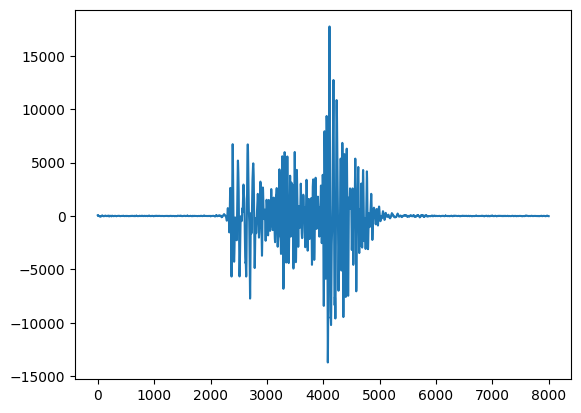

In [9]:
plt.plot(sig[9500:17500])

In [10]:
sign = normalize(sig[9500:17500])

In [11]:
time = np.linspace(0,1,8000)

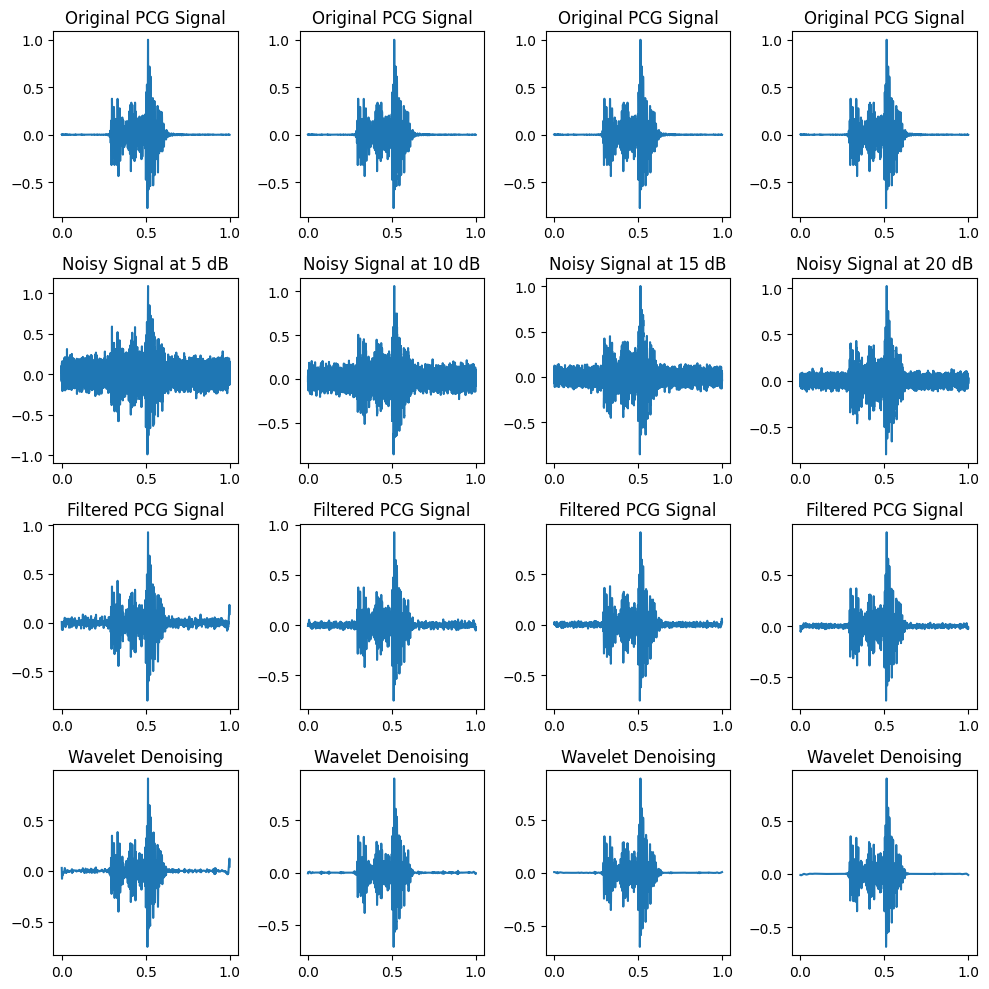

In [13]:
snr_levels = [5, 10, 15, 20]  # Different SNR levels
cols = [0, 1, 2, 3]
fig, axs = plt.subplots(4, 4, figsize=(10, 10))

for col, snr in zip(cols, snr_levels):
    # Original signal
    axs[0, col].plot(time, sign)
    axs[0, col].set_title("Original PCG Signal")
    
    # Add noise
    noisy_signal = add_noise(sign, snr)
    axs[1, col].plot(time, noisy_signal)
    axs[1, col].set_title(f"Noisy Signal at {snr} dB")
    
    # Filter signal
    filtered_signal = butter_bandpass_filter(noisy_signal, sr)
    # filtered_signal = wavelet_denoising(filtered_signal)
    axs[2, col].plot(time, filtered_signal)
    axs[2, col].set_title("Filtered PCG Signal")

    # Filter signal
    filtered_signal = wavelet_denoising(filtered_signal)
    axs[3, col].plot(time, filtered_signal)
    axs[3, col].set_title("Wavelet Denoising")

# Adjust layout
plt.tight_layout()
plt.show()

In [14]:
snr_levels = [5, 10, 15, 20]
results = []
for snr_db in snr_levels:
    noisy_signal = add_noise(sign, snr_db)
    filtered_signal = butter_bandpass_filter(noisy_signal, sr)
    denoised_signal = wavelet_denoising(filtered_signal)

    snr_noisy = calculate_snr(sign, noisy_signal)
    snr_filtered = calculate_snr(sign, filtered_signal)
    snr_denoised = calculate_snr(denoised_signal, filtered_signal)

    results.append([snr_noisy, snr_filtered, snr_denoised])

# Create a DataFrame to display the table
df = pd.DataFrame(results, columns=['SNR of Noisy Signal', 'SNR after Filtering', 'SNR after Denoising'], index=[f"{snr} dB" for snr in snr_levels])
print(df)

       SNR of Noisy Signal  SNR after Filtering  SNR after Denoising
5 dB              4.856844            24.532639            26.548286
10 dB             9.818956            27.779064            27.313365
15 dB            14.961996            31.756159            28.726330
20 dB            19.854615            34.472454            30.415882


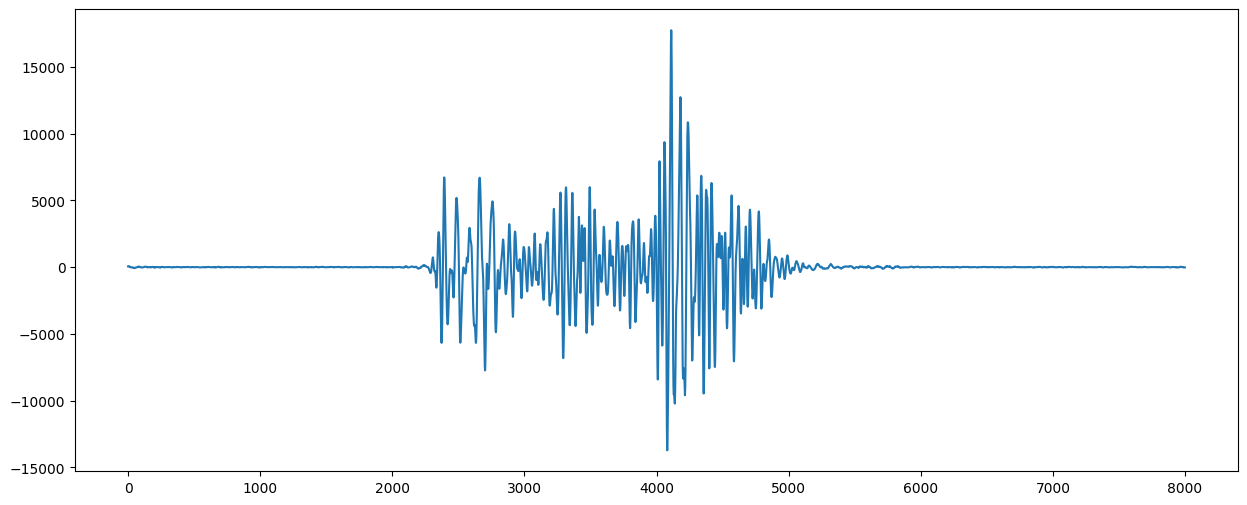

In [35]:
plt.figure(figsize=(15, 6))
plt.plot(sig[9500:17500])

In [23]:
q =  sr//2000 # Decimation factor
sig2d = signal.decimate(sig, q, zero_phase=True)

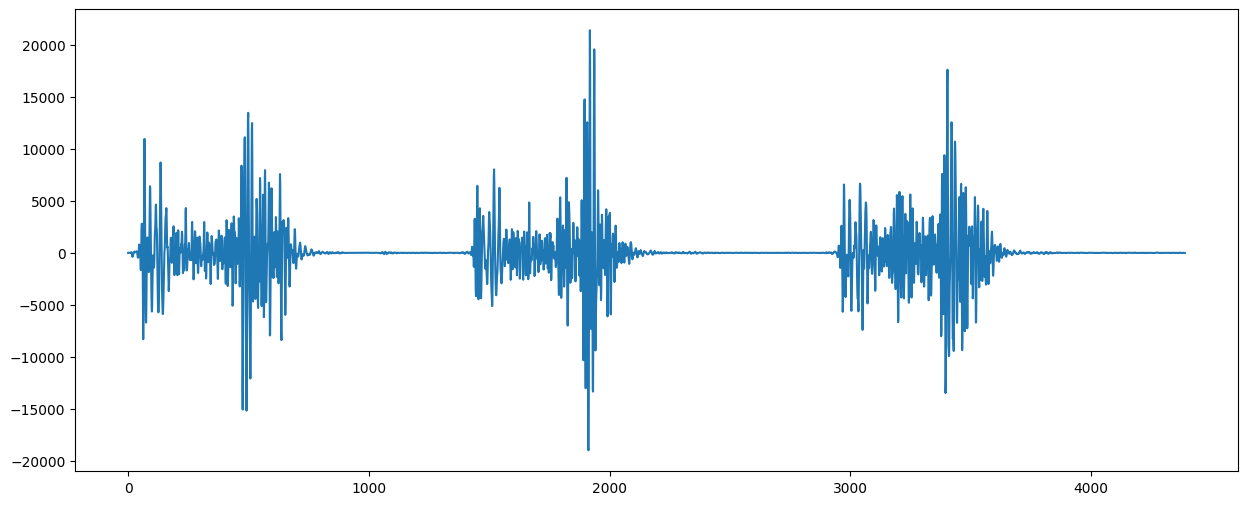

In [24]:
plt.figure(figsize=(15, 6))
t = np.linspace
plt.plot(sig2d)